In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
batch_size = 32
num_stocks = 31
seq_len = 10
num_features = 10
num_market_features = num_features

beta = 0.01
units = 64
ft_dim = 32
n_heads = 12

In [ ]:
import numpy as np
import pandas as pd

def __market_stock_split(df):
    market_df = df[df.code=='U182']
    stock_df = df[df.code!='U182']
    return market_df, stock_df

def __stock_seperate(stocks):
    stock_names = stocks['name'].unique()
    res = []
    for stock in stock_names:
        res.append(stocks[stocks.name==stock])
    return res

def __train_test_split(stocks_df, test_pct=0.2, valid_pct=0.2):
    if not isinstance(stocks_df, (list, tuple)):
        return __train_test_split([stocks_df], test_pct, valid_pct)

    stocks_train, stocks_valid, stocks_test = [],[],[]
    for stock in stocks_df:
        test_size = int(len(stock)*test_pct)
        valid_size = int(len(stock)*valid_pct)
        train_size = len(stock) - test_size - valid_size

        stocks_train.append(stock[:train_size])
        stocks_valid.append(stock[train_size:train_size+valid_size])
        stocks_test.append(stock[-test_size:])

    return stocks_train, stocks_valid, stocks_test

def __input_target_split(stocks_df):
    target = [stock['close'].apply(lambda x: int(x>0)) for stock in stocks_df]
    return stocks_df, target

def __window_split(inputs, targets, window_size=10):
    inputs = inputs.values
    targets = targets.values
    X = []
    y = []
    for i in range(window_size, len(inputs)):
        X.append(inputs[i-window_size:i])
        y.append(targets[i])

    return np.array(X), np.array(y)

def __stocks_window_split(stocks_inputs, stocks_target, window_size=10):
    X,y = [],[]
    for j in range(window_size, len(stocks_inputs[0])):
        bucket_X = []
        bucket_y = []
        for i in range(len(stocks_inputs)):
            stock = stocks_inputs[i].values
            target = stocks_target[i].values
            bucket_X.append(stock[j-window_size:j])
            bucket_y.append(target[j])
        X.append(bucket_X)
        y.append(bucket_y)
    return np.array(X), np.array(y)

def prepare_data(path, **kwargs):
    df = pd.read_csv(path)
    market, stocks = __market_stock_split(df)
    stocks = __stock_seperate(stocks)
    print(len(stocks))
    for i in range(len(stocks)):
        stocks[i].drop(['code','name', 'date'], axis=1, inplace=True)
    market.drop(['code','name', 'date'], axis=1, inplace=True)

    market_train_valid_test = __train_test_split(market,
                                                 test_pct=kwargs.get('test_pct'),
                                                 valid_pct=kwargs.get('valid_pct')) # [m_train], [m_valid], [m_test]
    stock_train_valid_test = __train_test_split(stocks,
                                                test_pct=kwargs.get('test_pct'),
                                                valid_pct=kwargs.get('valid_pct')) # [s_train1, ...], [s_valid1, ...], [s_test1, ...]

    market_data = [__input_target_split(m) for m in market_train_valid_test] # [([m_train_X], [m_train_y]), (...), (...)]
    stock_data = [__input_target_split(s) for s in stock_train_valid_test] # [([s_train1_X, ...], [s_train1_y, ...]), (...), (...)]

    window_size = kwargs['window_size']
    market_data = [__stocks_window_split(*m, window_size) for m in market_data]
    stock_data = [__stocks_window_split(*s, window_size) for s in stock_data]
    return market_data, stock_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import os
path = os.path.abspath('/content/drive/MyDrive/programmers/project/data/preprocessed_kospi31_daily_stock_chart.csv')
option = {
    'window_size':seq_len,
    'test_pct':0.2,
    'valid_pct':0.2
}
market_data, stock_data = prepare_data(path, **option)
(X_train_m, y_train_m), (X_valid_m, y_valid_m), (X_test_m, y_test_m) = market_data
(X_train_s, y_train_s), (X_valid_s, y_valid_s), (X_test_s, y_test_s) = stock_data

31


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
from tensorflow.python.keras.layers import Layer, Dense, LSTM, Dropout, LayerNormalization, Input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import MultiHeadAttention

class FeatureTransformation(Layer):
    def __init__(self, ft_dim):
        super(FeatureTransformation, self).__init__()
        self.ft_dim = ft_dim

    def build(self, input_shape):
        self.ft_linear = Dense(self.ft_dim,
                               input_shape=input_shape,
                               kernel_initializer='glorot_uniform',
                               bias_initializer='glorot_uniform',
                               activation='tanh')

    def call(self, inputs, *args, **kwargs):
        x = tf.reshape(inputs, shape=(-1, inputs.shape[2], inputs.shape[3]))
        x = self.ft_linear(x)
        return x

    def get_config(self):
        config = super().get_config().copy()
        config.update({'ft_dim': self.ft_dim})
        return config


class AttentionLSTM(Layer):
    def __init__(self, units, num_stocks):
        super(AttentionLSTM, self).__init__()
        self.units = units
        self.num_stocks = num_stocks

    def build(self, input_shape):
        self.lstm = LSTM(self.units, return_sequences=True, return_state=False)

    def call(self, inputs, *args, **kwargs):
        feature = self.lstm(inputs)
        attn = tf.matmul(feature, feature[:,-1:,:], transpose_b=True)
        attn = tf.nn.softmax(attn, axis=-1)

        attn = tf.reshape(attn, shape=(-1, self.num_stocks, attn.shape[1], attn.shape[2]))
        feature = tf.reshape(feature, shape=(-1, self.num_stocks, feature.shape[1], feature.shape[2]))
        context = tf.reduce_sum(attn*feature, axis=2)
        return context

    def get_config(self):
        config = super().get_config().copy()
        config.update({'units': self.units,
                       'num_stocks:':self.num_stocks})
        return config


class ContextNormalize(Layer):
    def __init__(self):
        super(ContextNormalize, self).__init__()

    def build(self, input_shape):
        shape = input_shape[1:]
        self.norm_weight = self.add_weight(name='norm_weight',
                                           shape=shape,
                                           initializer='uniform',
                                           trainable=True)

        self.norm_bias = self.add_weight(name='norm_bias',
                                         shape=shape,
                                         initializer='uniform',
                                         trainable=True)

    def call(self, context, *args, **kwargs):
        context = (context - tf.math.reduce_mean(context))/tf.math.reduce_std(context)
        context = self.norm_weight*context+self.norm_bias
        return context

    def get_config(self):
        config = super(ContextNormalize, self).get_config().copy()
        return config


class MultiLevelAggregator(Layer):
    def __init__(self, beta):
        super(MultiLevelAggregator, self).__init__()
        self.beta = beta

    def call(self, inputs, *args, **kwargs):
        stocks_context = inputs[0]
        market_context = inputs[1]
        multi_context = stocks_context + self.beta*market_context
        multi_context = tf.matmul(multi_context, multi_context, transpose_b=True)
        return multi_context

    def get_config(self):
        config = super(MultiLevelAggregator, self).get_config().copy()
        config.update({'beta':self.beta})
        return config


class SingleAttention(Layer):
    def __init__(self):
        super(SingleAttention, self).__init__()

    def build(self, input_shape):
        self.hidden_shape = input_shape[0][-1]
        self.query = Dense(self.hidden_shape,
                           name='query_weight',
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')
        self.key = Dense(self.hidden_shape,
                         name='key_weight',
                         input_shape=input_shape,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='glorot_uniform')
        self.value = Dense(self.hidden_shape,
                           name='value_weight',
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

    def call(self, inputs, *args, **kwargs):
        q = self.query(inputs[0])
        k = self.key(inputs[1])
        v = self.value(inputs[2])

        attn_weight = tf.matmul(q, k, transpose_b=True)
        attn_weight = tf.map_fn(lambda x: x/np.sqrt(self.hidden_shape), attn_weight)
        attn_weight = tf.nn.softmax(attn_weight, axis=-1)
        attn_weight = tf.matmul(attn_weight, v)
        return attn_weight


class MultiAttention(Layer):
    def __init__(self, n_heads):
        super(MultiAttention, self).__init__()
        self.n_heads = n_heads

    def build(self, input_shape):
        self.attn_heads = [SingleAttention() for i in range(self.n_heads)]
        self.linear = Dense(input_shape[0][-1],
                            name='multi_attn_linear',
                            input_shape=input_shape,
                            kernel_initializer='glorot_uniform',
                            bias_initializer='glorot_uniform')

    def call(self, inputs, *args, **kwargs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        attn = tf.concat(attn, axis=-1)
        attn = self.linear(attn)
        return attn

    def get_config(self):
        config = super(MultiAttention, self).get_config().copy()
        config.update({'n_heads':self.n_heads})
        return config


class NonlinearPrediction(Layer):
    def __init__(self):
        super(NonlinearPrediction, self).__init__()

    def build(self, input_shape):
        self.hidden_size = input_shape[0][-1]
        self.mlp_linear1 = Dense(4*self.hidden_size,
                                 name='mlp_linear1',
                                 input_shape=input_shape,
                                 kernel_initializer='glorot_uniform',
                                 bias_initializer='glorot_uniform')

        self.mlp_linear2 = Dense(self.hidden_size,
                                 name='mlp_linear2',
                                 kernel_initializer='glorot_uniform',
                                 bias_initializer='glorot_uniform')

        self.dropout = Dropout(0.15)
        self.layer_norm = LayerNormalization(input_shape=input_shape,
                                             epsilon=1e-6)
        self.pred_linear = Dense(1,
                                 name='pred_linear',
                                 input_shape=input_shape,
                                 kernel_initializer='glorot_uniform',
                                 bias_initializer='glorot_uniform',
                                 kernel_regularizer='l2',
                                 bias_regularizer='l2',
                                 activation='sigmoid')

    def call(self, inputs, *args, **kwargs):
        context, attn_weights = inputs[0], inputs[1]
        residual_context = context + attn_weights

        mlp_context = self.mlp_linear1(residual_context)
        mlp_context = self.mlp_linear2(mlp_context)

        residual_context = tf.nn.tanh(residual_context + mlp_context)
        residual_context = self.dropout(residual_context)
        residual_context = self.layer_norm(residual_context)

        output = self.pred_linear(residual_context)
        return output

    def get_config(self):
        config = super(NonlinearPrediction, self).get_config().copy()
        config.update({'hiddn_size':self.hidden_size})
        return config

In [ ]:
from keras import backend as K
from tensorflow.python.keras.optimizer_v2 import adam

def mcc(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())
  
def create_model():
    feature_trans_stock = FeatureTransformation(ft_dim)
    feature_trans_market = FeatureTransformation(ft_dim)
    attn_lstm_stock = AttentionLSTM(units, num_stocks)
    attn_lstm_market = AttentionLSTM(units, 1)
    context_norm_stock = ContextNormalize()
    context_norm_market = ContextNormalize()
    multi_lvl_aggregator = MultiLevelAggregator(beta)
    data_axis_attention = MultiAttention(n_heads)

    dropout = Dropout(0.15)
    layer_norm = LayerNormalization(epsilon=1e-6)
    nonlinear_pred = NonlinearPrediction()

    stock_inputs = Input(shape=(num_stocks, seq_len, num_features))
    market_inputs = Input(shape=(1, seq_len, num_market_features))

    stock_features = feature_trans_stock(stock_inputs)
    market_features = feature_trans_market(market_inputs)
    stock_attn = context_norm_stock(attn_lstm_stock(stock_features))
    market_attn = context_norm_market(attn_lstm_market(market_features))

    context = multi_lvl_aggregator([stock_attn, market_attn])

    attn_weight = data_axis_attention((context, context, context))
    attn_weight = dropout(attn_weight)
    attn_weight = layer_norm(attn_weight)
    output = nonlinear_pred([context, attn_weight])

    opt = adam.Adam(learning_rate=0.0001)
    model = Model(inputs=[stock_inputs, market_inputs], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', mcc])
    return model

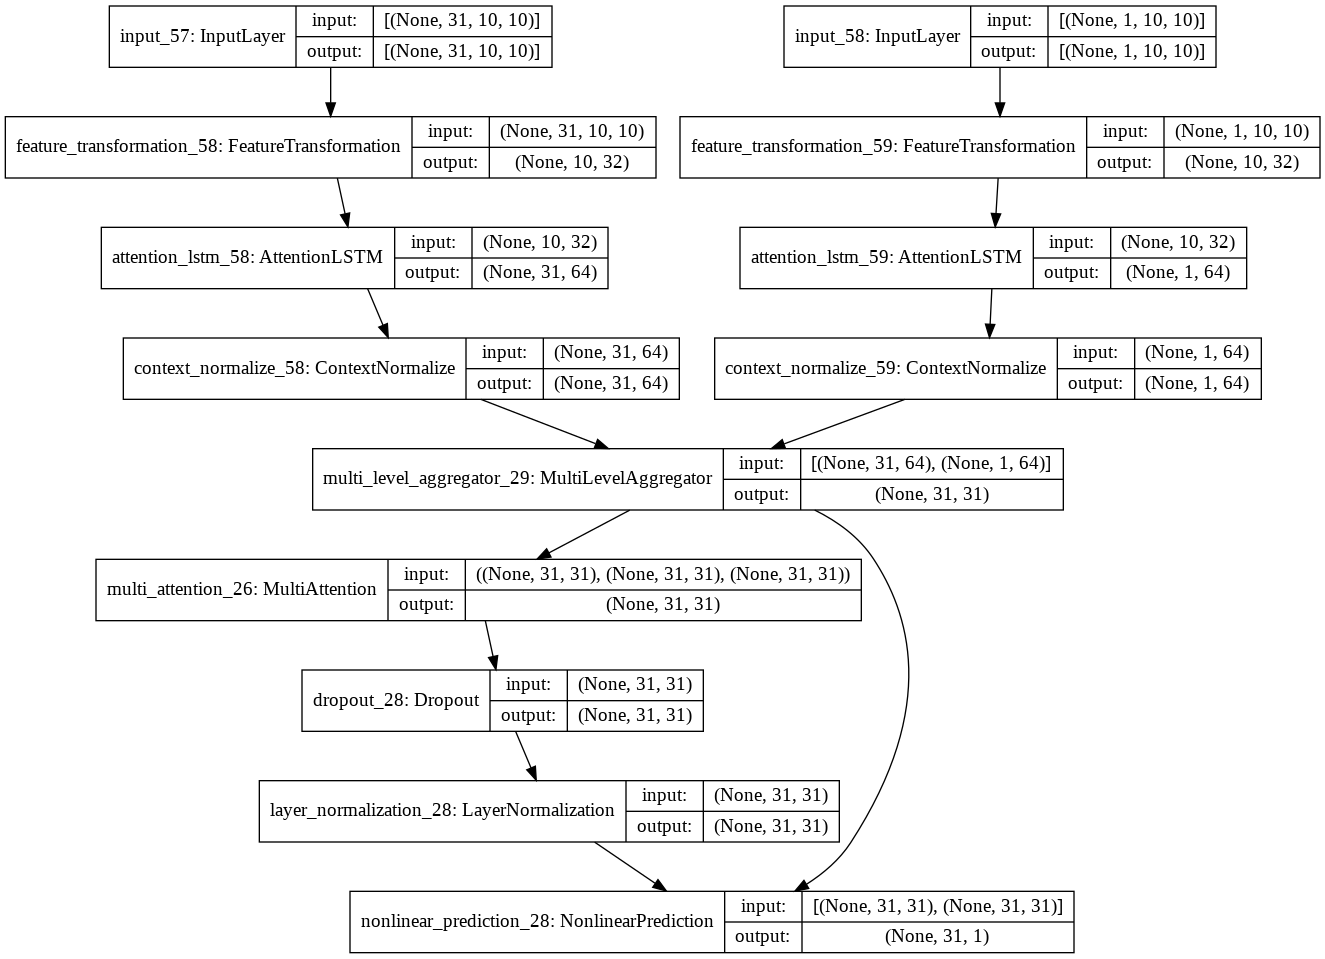

In [ ]:
from tensorflow.python.keras.utils.vis_utils import plot_model
model = create_model()
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('dtml.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(x=(X_train_s, X_train_m), y=y_train_s, epochs=200,
                    validation_data=((X_valid_s, X_valid_m), y_valid_s),
                    callbacks=[es, mc])

Epoch 1/200
87/87 [==============================] - 40s 320ms/step - loss: 0.9311 - accuracy: 0.4974 - mcc: 0.0015 - val_loss: 0.7404 - val_accuracy: 0.5283 - val_mcc: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.52831, saving model to dtml.h5
Epoch 2/200
87/87 [==============================] - 26s 295ms/step - loss: 0.7753 - accuracy: 0.5017 - mcc: -0.0072 - val_loss: 0.7338 - val_accuracy: 0.5283 - val_mcc: 0.0000e+00

Epoch 00002: val_accuracy did not improve from 0.52831
Epoch 3/200
87/87 [==============================] - 27s 306ms/step - loss: 0.7671 - accuracy: 0.5043 - mcc: -0.0018 - val_loss: 0.7325 - val_accuracy: 0.5283 - val_mcc: 0.0000e+00

Epoch 00003: val_accuracy did not improve from 0.52831
Epoch 4/200
87/87 [==============================] - 25s 288ms/step - loss: 0.7627 - accuracy: 0.5062 - mcc: 0.0037 - val_loss: 0.7317 - val_accuracy: 0.5283 - val_mcc: 0.0000e+00

Epoch 00004: val_accuracy did not improve from 0.52831
Epoch 5/200
87/87 [=========

In [ ]:
train_pred = model.predict((X_train_s, X_train_m))
val_pred = model.predict((X_valid_s, X_valid_m))
test_pred = model.predict((X_test_s, X_test_m))

# #Print evaluation metrics for all datasets
train_eval = model.evaluate((X_train_s, X_train_m), y_train_m, verbose=0)
val_eval = model.evaluate((X_valid_s, X_valid_m), y_valid_m, verbose=0)
test_eval = model.evaluate((X_test_s, X_test_m), y_test_m, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, ACC: {:.4f}, MCC: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, ACC: {:.4f}, MCC: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, ACC: {:.4f}, MCC: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.6954, ACC: 0.5461, MCC: 0.1345
Validation Data - Loss: 0.7177, ACC: 0.4805, MCC: -0.0299
Test Data - Loss: 0.7223, ACC: 0.4819, MCC: 0.0270


In [ ]:
print(train_pred.shape)
print(val_pred.shape)
print(test_pred.shape)
print(y_train_m.shape)
print(y_valid_m.shape)
print(y_test_m.shape)


(2762, 31, 1)
(914, 31, 1)
(914, 31, 1)
(2762, 1)
(914, 1)
(914, 1)


In [ ]:
model.save('/content/drive/MyDrive/programmers/project/model/DTML_.h5')

In [ ]:
stock1 = []
for tp in test_pred[:10]:
  for i in range(len(tp)):
    if i == 0:
      stock1.append(tp[i])
    print(tp[i][0], end=" ")
  print()

0.4486988 0.47403967 0.47872093 0.49419194 0.51509154 0.47935823 0.4951999 0.5081876 0.48944834 0.47367692 0.4200038 0.47678268 0.46751654 0.46977326 0.48456717 0.46350592 0.4767997 0.45431557 0.4886407 0.47581547 0.46265793 0.47673368 0.46638533 0.49016127 0.4646793 0.46681076 0.4633427 0.47342825 0.4618066 0.49515393 0.49710622 
0.4462641 0.472543 0.4741208 0.4923136 0.5166543 0.47516206 0.4925431 0.49614412 0.48689833 0.47137064 0.41553888 0.47675624 0.4657022 0.4659206 0.48111117 0.4615643 0.47567853 0.44760182 0.48951837 0.47490823 0.4564224 0.47448626 0.46350235 0.48582262 0.46072233 0.45866054 0.4596823 0.46757758 0.46009865 0.49494973 0.49397054 
0.4479404 0.4800848 0.4773615 0.4973768 0.5207908 0.47739574 0.49487042 0.49725887 0.485834 0.4708821 0.41906145 0.4791949 0.47115895 0.4697329 0.48417813 0.46405494 0.48055553 0.44990662 0.48847678 0.4798373 0.45880917 0.47742894 0.46657842 0.48773053 0.46767855 0.46115157 0.46185318 0.46811053 0.46413392 0.50040185 0.49895778 
0.4308

In [ ]:
label = []
for y_t in y_test_m[:10]:
  print(y_t[0], end=" ")
  label.append(y_t[0])

1 1 1 0 0 1 0 1 1 1 

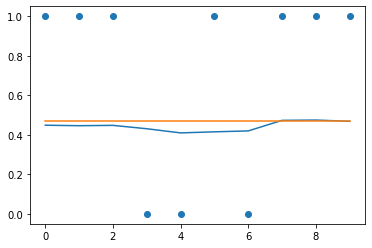

In [ ]:
import matplotlib.pyplot as plt

plt.plot(stock1)
plt.plot([0.47 for _ in range(10)])
plt.scatter([i for i in range(10)], label)